In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Input
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
def residual_block(input_tensor, filters, kernel_size, strides=1, downsample=None):
    y = Conv1D(filters, kernel_size=kernel_size, padding='same', strides=strides)(input_tensor)
    y = BatchNormalization()(y)
    y = ReLU()(y)

    y = Conv1D(filters, kernel_size=kernel_size, padding='same', strides=1)(y)
    y = BatchNormalization()(y)

    if downsample:
        input_tensor = Conv1D(filters, kernel_size=1, strides=strides, padding='same')(input_tensor)
        input_tensor = BatchNormalization()(input_tensor)

    y = Add()([input_tensor, y])
    y = ReLU()(y)
    return y

In [14]:
def build_resnet(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)

    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3, strides=2, downsample=True)
    x = residual_block(x, 256, 3, strides=2, downsample=True)

    x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes)(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [15]:
def load_and_preprocess_data(filename):
    data = pd.read_csv(filename)
    data = data.transpose()
    data.columns = data.iloc[0]
    data = data[1:]

    close_prices = data['4. close'].astype(float).values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(close_prices)

    return normalized_data, scaler

data, scaler = load_and_preprocess_data('AAPL_stock_data_alpha.csv')

In [16]:
def create_dataset(data, look_back=60):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [18]:
X, Y = create_dataset(data)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = build_resnet((X_train.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

test_loss, test_mae = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.4646 - mae: 0.3889 - val_loss: 0.0690 - val_mae: 0.1822
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0100 - mae: 0.0666 - val_loss: 0.0431 - val_mae: 0.1380
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0041 - mae: 0.0428 - val_loss: 0.0419 - val_mae: 0.1275
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0036 - mae: 0.0405 - val_loss: 0.0269 - val_mae: 0.1098
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0030 - mae: 0.0364 - val_loss: 0.0152 - val_mae: 0.0841
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0047 - mae: 0.0434 - val_loss: 0.0078 - val_mae: 0.0562
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0024 - mae: 0.0322 - val_loss: 0.0029 - val_mae: 0.0474
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0027 - mae: 0.0360 - val_loss: 0.0021 - val_mae: 0.0381
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms

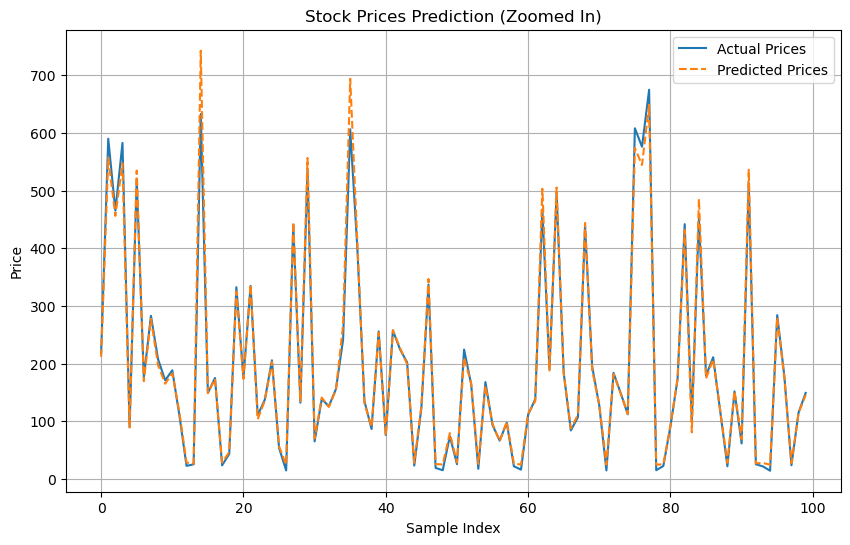

In [20]:
# Define the range for zooming in
start_index = 0
end_index = 100

# Slice the actual and predicted arrays to the desired range
actual_zoomed = actual[start_index:end_index]
predictions_zoomed = predictions[start_index:end_index]

plt.figure(figsize=(10, 6))
plt.plot(range(start_index, end_index), actual_zoomed, label='Actual Prices')
plt.plot(range(start_index, end_index), predictions_zoomed, label='Predicted Prices', linestyle='--')
plt.title('Stock Prices Prediction (Zoomed In)')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
model = build_resnet((X_train.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

test_loss, test_mae = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 94s 146ms/step - loss: 0.4892 - mae: 0.4018 - val_loss: 0.0648 - val_mae: 0.1672
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.0107 - mae: 0.0705 - val_loss: 0.0470 - val_mae: 0.1612
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.0042 - mae: 0.0428 - val_loss: 0.0471 - val_mae: 0.1559
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - loss: 0.0045 - mae: 0.0456 - val_loss: 0.0395 - val_mae: 0.1339
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.0048 - mae: 0.0471 - val_loss: 0.0222 - val_mae: 0.0962
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - loss: 0.0046 - mae: 0.0428 - val_loss: 0.0044 - val_mae: 0.0431
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.0030 - mae: 0.0340 - val_loss: 9.0135e-04 - val_mae: 0.0190
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - loss: 0.0027 - mae: 0.0337 - val_loss: 0.0015 - val_mae: 0.0306
Epoch 9/20
123/123 ━━━━━━━━━

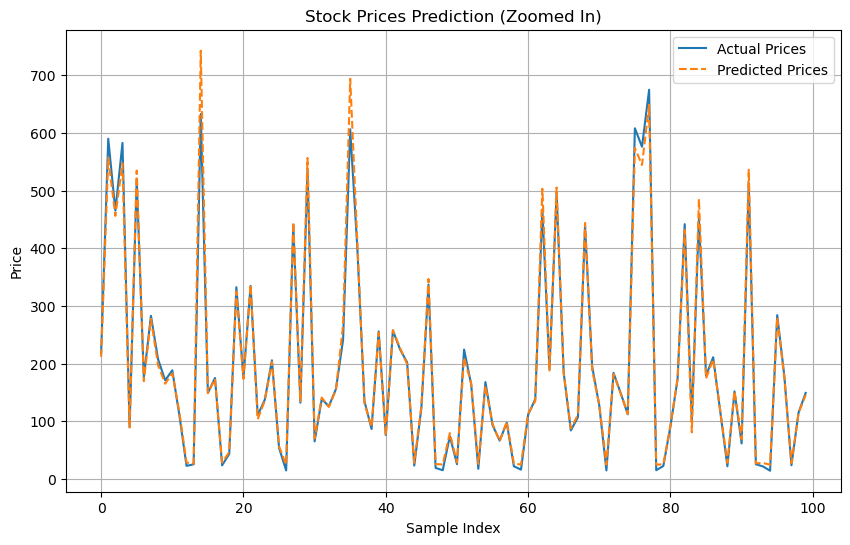

In [22]:
# Define the range for zooming in
start_index = 0
end_index = 100

# Slice the actual and predicted arrays to the desired range
actual_zoomed = actual[start_index:end_index]
predictions_zoomed = predictions[start_index:end_index]

plt.figure(figsize=(10, 6))
plt.plot(range(start_index, end_index), actual_zoomed, label='Actual Prices')
plt.plot(range(start_index, end_index), predictions_zoomed, label='Predicted Prices', linestyle='--')
plt.title('Stock Prices Prediction (Zoomed In)')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()